**IMPORT**

In [ ]:
# Import of required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os

In [ ]:
# Google drive import if do generation in Colab
from google.colab import drive   
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**PART 1:**

After using image capturing script the result is folder "data_from_camera", where each subfolder contain images of only one class 
(in this case 100 images for each class):


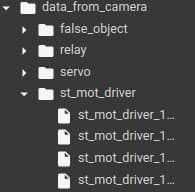


After use this script (PART 1) the result is another folder "augmented_data" with the same directory structure, but where each subfolder contains n-times more generated images (in original: 100 images per class; generated: 300 images per class). In this case, "num" = 3.


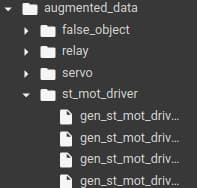



**SET-UP**

In [ ]:
# Generation parameters setup. Available arguments: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                  rotation_range=90,
                                  horizontal_flip=False,
                                  vertical_flip=False)

# Path to directory with training/validation/tests folder
dataset_dir = "/content/gdrive/MyDrive/cv_automation/data_from_camera/"

# Path to directory for saving of generated images
saving_dir = "/content/gdrive/MyDrive/cv_automation/augmented_data/"

if not (os.path.exists(saving_dir)):  # Creating saving directory if not exist
  os.makedirs(saving_dir, exist_ok=False)
  print(f"The directory \"{saving_dir}\" for saving is created!")


num = 3 # Quantity of images, which need to generate for each image
im_format = 'jpg' # Image saving format: jpg, png, etc.

**GENERATION FOR SINGLE CLASS FOLDER**


In [ ]:

# Getting names of classes' folders for generation as list
folders_list = glob.glob(dataset_dir+"*/")
for i in range(len(folders_list)):
  folders_list[i] = (folders_list[i].split('/')[-2])

print("Folders list:",folders_list)

# Just for check, not important:
# folder = folders_list[0] 
# print(folder)

Folders list: ['false_object', 'servo', 'relay', 'st_mot_driver']
false_object


Generation process started. Please, wait...
Class' folder "st_mot_driver" is created in "/content/gdrive/MyDrive/cv_automation/augmented_data/"!
The image generation process is complete.


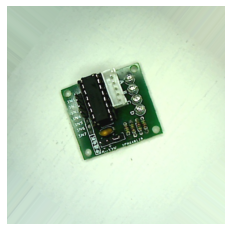

In [ ]:
# Choose folder in code above or just write a name in line below
folder = 'st_mot_driver'

plt.axis('off') # Remove scale of measure from images

print("Generation process started. Please, wait...")

img_path_list = (glob.glob(dataset_dir +folder+"/*.jpg")) #Getting paths to all images in class' folder as list

counter = 1 # Images' name postfix for image saving (will be incremented after each generation)

for img_path in img_path_list:
  img = image.load_img(img_path, target_size=(500, 500)) #Loading the image as source for generation with resizing to target size

    # Converting of image to a numeric array
  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  i = 0 #Counter of generated images based on 1 souce image

    # IMAGE GENERATION
  for batch in train_datagen.flow(x, batch_size=1):
    mgplot = plt.imshow(image.array_to_img(batch[0])) #Converting of generated array back to an image
    i += 1

      # Creating class folder for saving if not exist
    if not (os.path.exists(saving_dir + folder)):  #Creating saving directory if not exist
      os.makedirs(saving_dir + folder, exist_ok=False)
      print(f"Class' folder \"{folder}\" is created in \"{saving_dir}\"!")

      # Parameters of saving of generated image
    plt.savefig(saving_dir+folder+'/gen_'+folder+'_' +str(counter) + '.'+im_format , bbox_inches='tight', pad_inches=0, dpi=85) #!Generated image is plot!
    counter +=1
      
    if i % num == 0: # Break of generation loop for current source image 
      break

print("The image generation process is complete.")

**PART 2:**

Copy original and augmented data to new single folder (combine all files from original data and generated data to a single folder).

In this case, there are folders "data_from_camera" with 100 images per class and "augmented_data" with 300 images per class. Task of this part is to combine content of this two folders into singe one "full_dataset". So, each subfolder of "full_dataset" contains now 400 images (400 images per each class).

In [ ]:
import shutil
import os
import glob
 
# path to source directory
src_1_dir = "/content/gdrive/MyDrive/cv_automation/data_from_camera/"
src_2_dir = "/content/gdrive/MyDrive/cv_automation/augmented_data/"
src_dir_list = [src_2_dir, src_1_dir]
# path to destination directory
dest_dir = "/content/gdrive/MyDrive/cv_automation/full_dataset/"

if not (os.path.exists(dest_dir)):  # Creating destination directory if not exist
  os.makedirs(dest_dir, exist_ok=False)
  print(f"The destination directory \"{dest_dir}\" is created!")

for source in src_dir_list:
  # getting all the files in the source directory
  folders = glob.glob(f"{source}*")
  for folder_ in folders:
    dest = dest_dir+folder_.split('/')[-1]
    if not (os.path.exists(dest)):  # Creating destination directory if not exist
      os.makedirs(dest, exist_ok=False)
      print(f"The destination directory \"{dest}\" is created!")
    files = glob.glob(f"{folder_}/*")
    for file_ in files:
      shutil.copy(file_,dest)


The destination directory "/content/gdrive/MyDrive/cv_automation/full_dataset/" is created!
The destination directory "/content/gdrive/MyDrive/cv_automation/full_dataset/false_object" is created!
The destination directory "/content/gdrive/MyDrive/cv_automation/full_dataset/servo" is created!
The destination directory "/content/gdrive/MyDrive/cv_automation/full_dataset/relay" is created!
The destination directory "/content/gdrive/MyDrive/cv_automation/full_dataset/st_mot_driver" is created!


**PART 3**

For neural network training there are need three datasets: for training, for validation (dev set) and for tests.

So, this script (PART 3) allow to shuffle all data and split it to train, dev and test sets according to the established percentages ("train_p", "dev_p" and "test_p" variables). For small dataset recomended are 60% for training, 20% for dev and test sets.

BE CAREFUL! This part was tested only with integer split result (400 images to: 240 for training (400 * 0.6), 80 images per class for dev and test sets). Not tested if result is float (e.g. 400 * 0.6 = 271.2). 

In [ ]:
import shutil
import os
import glob
import random

train_p = 60 # %
dev_p = 20   # %
test_p = 20  # %

if (train_p + dev_p + test_p) >100:
  print("Sum of three percentage variables must be smaller or equal 100.")
else:
  src_dir = "/content/gdrive/MyDrive/cv_automation/full_dataset/"
  dest_dir = "/content/gdrive/MyDrive/cv_automation/training_sets/"

  if not (os.path.exists(dest_dir)):  # Creating destination directory if not exist
    os.makedirs(dest_dir, exist_ok=False)
    print(f"The destination directory \"{dest_dir}\" is created!")

  folders = glob.glob(f"{src_dir}*")

  for d_set in ("train_set", "dev_set", "test_set"):
    for new_f in folders: #
      if not (os.path.exists(dest_dir+d_set+'/'+new_f.split('/')[-1])):  # Creating destination directory if not exist
        os.makedirs(dest_dir+d_set+'/'+new_f.split('/')[-1], exist_ok=False)

  for folder_ in folders:
    files = glob.glob(f"{folder_}/*")
    random.shuffle(files)
    num_files = len(files)
    print(folder_)

    for tr_f in files[0:int(num_files*(train_p/100))]:
      #print(0, int(num_files*(train_p/100)))
      shutil.copy(tr_f,dest_dir+"train_set/"+folder_.split('/')[-1])
    for dev_f in files[int(num_files*(train_p/100)):int(num_files*(train_p/100))+int(num_files*(dev_p/100))]:
      #print(int(num_files*(train_p/100)), int(num_files*(train_p/100))+int(num_files*(dev_p/100)))
      shutil.copy(dev_f,dest_dir+"dev_set/"+folder_.split('/')[-1])
    for te_f in files[int(num_files*(train_p/100))+int(num_files*(dev_p/100)):int(num_files*(train_p/100))+int(num_files*(dev_p/100))+int(num_files*(test_p/100))]:
      #print(int(num_files*(train_p/100))+int(num_files*(dev_p/100)), int(num_files*(train_p/100))+int(num_files*(dev_p/100))+int(num_files*(test_p/100)))
      shutil.copy(te_f,dest_dir+"test_set/"+folder_.split('/')[-1])


The destination directory "/content/gdrive/MyDrive/cv_automation/training_sets/" is created!
/content/gdrive/MyDrive/cv_automation/full_dataset/false_object
/content/gdrive/MyDrive/cv_automation/full_dataset/servo
/content/gdrive/MyDrive/cv_automation/full_dataset/relay
/content/gdrive/MyDrive/cv_automation/full_dataset/st_mot_driver
